# GenCast

### Colab setup

Run the following cell to setup the environment in colab:

In [ ]:
# Clone repo
!git clone https://github.com/openclimatefix/graph_weather.git

# Just for colab (to install torch-scatter, sparse and cluster in a faster way)
# See: https://stackoverflow.com/questions/67285115/building-wheels-for-torch-sparse-in-colab-takes-forever
import torch  # noqa: F401

%pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
%pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
%pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
%pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
%pip install git+https://github.com/pyg-team/pytorch_geometric.git
%pip install pyshtools
# Rename folder
!mv graph_weather graph_weather_repo
%cd graph_weather_repo

# Install other dependencies (ignore pandas error)
%pip install -r requirements.txt
%pip install pytest

# Install weatherbench
%pip install git+https://github.com/google-research/weatherbench2.git

# Pip might complain about the Pandas version. The notebook should still work as expected.
import apache_beam  # noqa: F401
import weatherbench2  # noqa: F401

# Run the code below to access cloud data on Colab!
from google.colab import auth  # type: ignore

auth.authenticate_user()

### Local setup

Assuming that everything else is already installed

In [ ]:
#%pip install git+https://github.com/google-research/weatherbench2.git

# Pip might complain about the Pandas version. The notebook should still work as expected.
import apache_beam  # noqa: F811, F401
import weatherbench2  # noqa: F811, F401

%cd ..

## Dataset and Dataloader

Set configuration for our datasets

In [12]:
atmospheric_features = ["geopotential", 
                        "specific_humidity",
                        "temperature",
                        "u_component_of_wind",
                        "v_component_of_wind",
                        "vertical_velocity"]
        
single_features = ["2m_temperature", 
                        "10m_u_component_of_wind",
                        "10m_v_component_of_wind",
                        "mean_sea_level_pressure",
                        #"sea_surface_temperature",
                        "total_precipitation_12hr"]

static_features = ["geopotential_at_surface", 
                        "land_sea_mask"]

#obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
#obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-512x256_equiangular_conservative.zarr'

batch_size = 2

In [20]:
import numpy as np
from torch.utils.data import DataLoader

from graph_weather.data.gencast_dataloader import BatchedGenCastDataset, GenCastDataset

# Uncomment the following lines to use dask multiworkers and cache
""""
import dask
from dask.cache import Cache
use_dask_cache = True
use_dask_multiworkers = True

if use_dask_multiworkers:
    dask.config.set(scheduler="threads", num_workers=4)
if use_dask_cache:
    cache = Cache(1e10)  # 10gb cache
    cache.register()
"""

# Classic dataset/dataloader
dataset_1 = GenCastDataset(
    obs_path=obs_path,
    atmospheric_features=atmospheric_features,
    single_features=single_features,
    static_features=static_features,
)
data_loader_1 = DataLoader(dataset_1, batch_size=batch_size)

# Batched dataset (we don't need a dataloader)
dataset_2 = BatchedGenCastDataset(
    obs_path=obs_path,
    atmospheric_features=atmospheric_features,
    single_features=single_features,
    static_features=static_features,
    batch_size=batch_size,
)

print("Loading the classic dataset")
x_1, noise_levels_1, ny_1, y_1 = next(iter(data_loader_1))
print("Loading the batched dataset")
x_2, noise_levels_2, ny_2, y_2 = dataset_2[0]
print("Checking that samples are exactly the same")
assert np.allclose(x_1, x_2)
assert np.allclose(y_1, y_2)
print("They are the same!")

Loading the classic dataset
Loading the batched dataset
Checking that samples are exactly the same
They are the same!


Plots

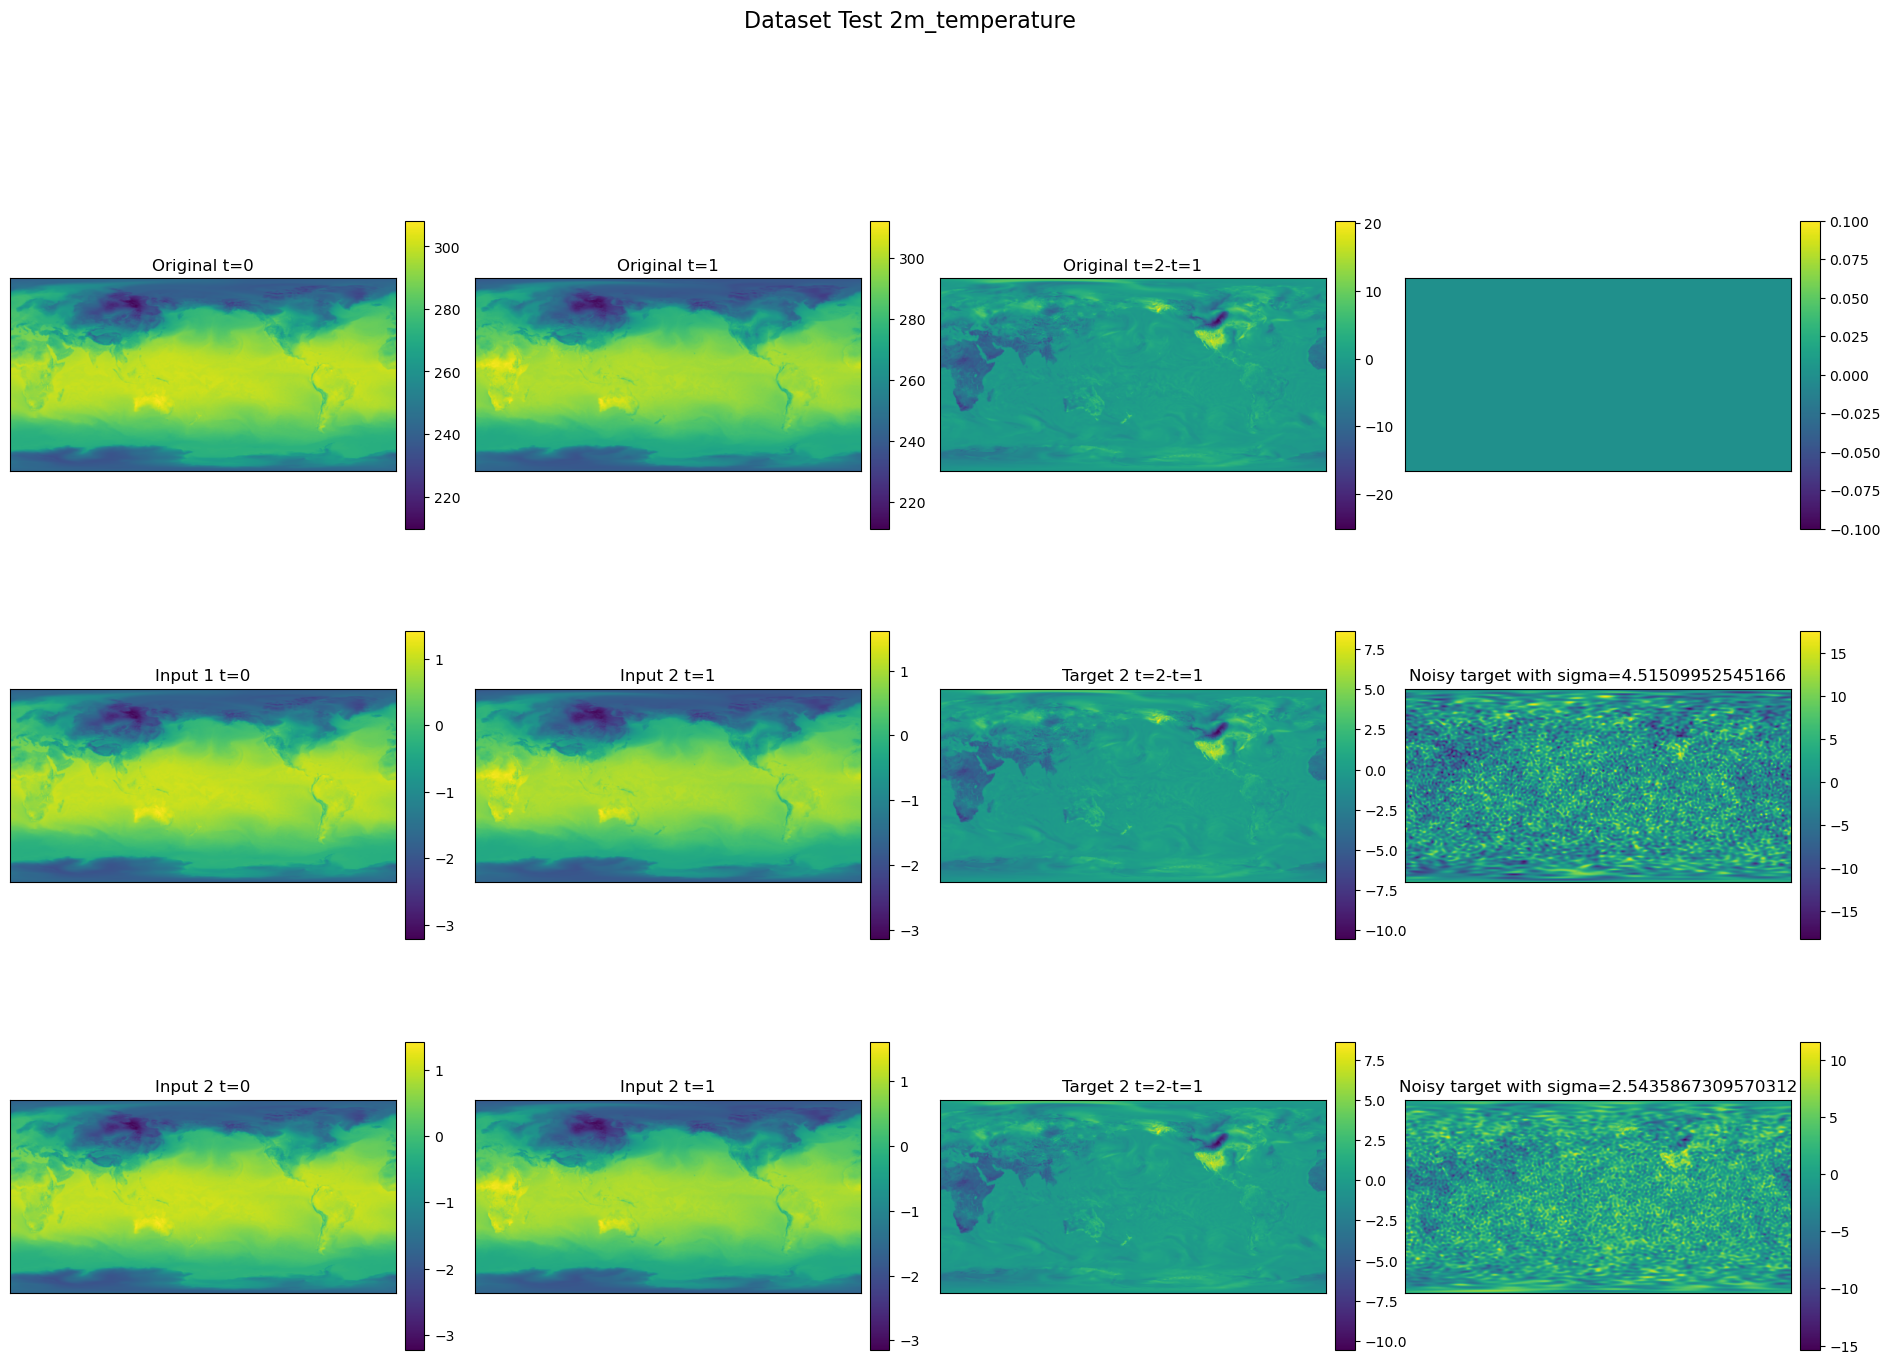

In [19]:
# Plots
import matplotlib.pyplot as plt
import xarray as xr

data = xr.open_zarr(obs_path, chunks={})

figure = plt.figure(figsize=(4 * 2 * 3, 4 * 4))
figure.suptitle("Dataset Test 2m_temperature", fontsize=16)
figure.subplots_adjust(wspace=0, hspace=0)
figure.tight_layout()

plot_data = [
    {"title": "Original t=0", "data": data.isel(time=0)["2m_temperature"].values},
    {"title": "Original t=1", "data": data.isel(time=2)["2m_temperature"].values},
    {
        "title": "Original t=2-t=1",
        "data": data.isel(time=4)["2m_temperature"].values
        - data.isel(time=2)["2m_temperature"].values,
    },
    {"title": "", "data": np.zeros_like(x_1[0][:,:,78])},
    {"title": "Input 1 t=0", "data": x_1[0][:, :, 78]},
    {"title": "Input 2 t=1", "data": x_1[0][:, :, 89 + 78]},
    {"title": "Target 2 t=2-t=1", "data": y_1[0][:, :, 78]},
    {
        "title": "Noisy target with sigma=" + str(noise_levels_1[0].item()),
        "data": ny_1[0][:, :, 78],
    },
    {"title": "Input 2 t=0", "data": x_2[0][:, :, 78]},
    {"title": "Input 2 t=1", "data": x_2[0][:, :, 89 + 78]},
    {"title": "Target 2 t=2-t=1", "data": y_2[0][:, :, 78]},
    {
        "title": "Noisy target with sigma=" + str(noise_levels_2[0].item()),
        "data": ny_2[0][:, :, 78],
    },
]

for i in range(12):
    ax = figure.add_subplot(3, 4, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(plot_data[i]["title"])
    im = ax.imshow(plot_data[i]["data"].T, origin="lower")
    plt.colorbar(mappable=im, ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.75)

In [10]:
print(x_1.shape)

torch.Size([2, 64, 32, 178])
